In [2]:
# import dependencies
import pandas as pd
import matplotlib as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_fscore_support
from scipy.stats import randint, uniform
from xgboost import XGBClassifier
import joblib
import json


In [3]:
# look the dataset over
df=pd.read_csv('Resources/data.csv',delimiter=';')
df['Target'] = pd.Categorical(df['Target'])
df['Target'] = df['Target'].cat.codes
print(df['Target'].value_counts())
df.head()

Target
2    2209
0    1421
1     794
Name: count, dtype: int64


Marital status  Application mode  Application order  Course  \
0               1                17                  5     171   
1               1                15                  1    9254   
2               1                 1                  5    9070   
3               1                17                  2    9773   
4               2                39                  1    8014   

   Daytime/evening attendance\t  Previous qualification  \
0                             1                       1   
1                             1                       1   
2                             1                       1   
3                             1                       1   
4                             0                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           122.0            1                      19   
1                           160.0            1                       1   
2                           122.0            1                      37   
3                           122.0            1                      38   
4                           100.0            1                      37   

   Father's qualification  ...  Curricular units 2nd sem (credited)  \
0                      12  ...                                    0   
1                       3  ...                                    0   
2                      37  ...                                    0   
3                      37  ...                                    0   
4                      38  ...                                    0   

   Curricular units 2nd sem (enrolled)  \
0                                    0   
1                                    6   
2                                    6   
3                                    6   
4                                    6   

   Curricular units 2nd sem (evaluations)  \
0                                       0   
1                                       6   
2                                       0   
3                                      10   
4                                       6   

   Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
0                                    0                          0.000000   
1                                    6                         13.666667   
2                                    0                          0.000000   
3                                    5                         12.400000   
4                                    6                         13.000000   

   Curricular units 2nd sem (without evaluations)  Unemployment rate  \
0                                               0               10.8   
1                                               0               13.9   
2                                               0               10.8   
3                                               0                9.4   
4                                               0               13.9   

   Inflation rate   GDP  Target  
0             1.4  1.74       0  
1            -0.3  0.79       2  
2             1.4  1.74       0  
3            -0.8 -3.12       2  
4            -0.3  0.79       2  

[5 rows x 37 columns]

In [4]:
def load_data(path,target_column,categorical=None,delimiter=','):
    df=pd.read_csv(path,delimiter=delimiter)
    df[target_column] = pd.Categorical(df[target_column])
    df[target_column] = df[target_column].cat.codes
    print(df[target_column].value_counts())
    y=df[target_column]
    X=df.drop(columns=target_column)
    if categorical != None:
        X=pd.get_dummies(X,columns=categorical).astype(int) # I put astype int here because my enviorment has some quirk where get dummies gives boolean values
    X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1,test_size=0.2, stratify=y)
    return X_train,X_test,y_train,y_test

In [5]:
# train basic model for comparison
path='Resources/data.csv'
delimiter = ';'
target_column='Target'
categorical=['Marital status','Application mode','Course','Previous qualification','Nacionality',"Mother's qualification","Father's qualification","Mother's occupation","Father's occupation",]
X_train,X_test,y_train,y_test=load_data(path=path,target_column=target_column,categorical=categorical,delimiter=delimiter)
xgb_clf=XGBClassifier()
xgb_clf.fit(X_train,y_train,eval_set=[(X_test,y_test)])
predict = xgb_clf.predict(X_test)
print(classification_report(y_test,predict))


Target
2    2209
0    1421
1     794
Name: count, dtype: int64
[0]	validation_0-mlogloss:0.90005
[1]	validation_0-mlogloss:0.78280
[2]	validation_0-mlogloss:0.70876
[3]	validation_0-mlogloss:0.66171
[4]	validation_0-mlogloss:0.62948
[5]	validation_0-mlogloss:0.60745
[6]	validation_0-mlogloss:0.59162
[7]	validation_0-mlogloss:0.57958
[8]	validation_0-mlogloss:0.57502
[9]	validation_0-mlogloss:0.56936
[10]	validation_0-mlogloss:0.56657
[11]	validation_0-mlogloss:0.56311
[12]	validation_0-mlogloss:0.56124
[13]	validation_0-mlogloss:0.55909
[14]	validation_0-mlogloss:0.55562
[15]	validation_0-mlogloss:0.55408
[16]	validation_0-mlogloss:0.55382
[17]	validation_0-mlogloss:0.55389
[18]	validation_0-mlogloss:0.55405
[19]	validation_0-mlogloss:0.55293
[20]	validation_0-mlogloss:0.55180
[21]	validation_0-mlogloss:0.55095
[22]	validation_0-mlogloss:0.55118
[23]	validation_0-mlogloss:0.55075
[24]	validation_0-mlogloss:0.55213
[25]	validation_0-mlogloss:0.55311
[26]	validation_0-mlogloss:0.55431
[2

In [10]:
# Defualt model
predict = xgb_clf.predict(X_test)
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.82      0.74      0.78       284
           1       0.55      0.45      0.50       159
           2       0.81      0.91      0.86       442

    accuracy                           0.78       885
   macro avg       0.73      0.70      0.71       885
weighted avg       0.77      0.78      0.77       885



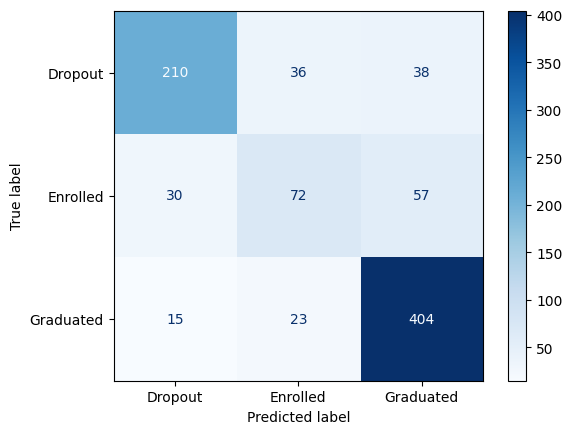

In [12]:
# Show matrix for a visual check
cnf_matrix = confusion_matrix(y_test, predict)
cmd = ConfusionMatrixDisplay(cnf_matrix, display_labels=['Dropout', 'Enrolled', 'Graduated'])
cmd.plot(cmap=plt.cm.Blues)

In [10]:
# create a list of weight combinations for optimization
weight_options = {
    'class_0': [.2,.3,.4,.5,.6,.7,.8,.9,1],
    'class_1': [1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2],
    'class_2': [.2,.3,.4,.5,.6,.7,.8,.9,1]
}
weight_combinations=[]
for w0 in weight_options['class_0']:
    for w1 in weight_options['class_1']:
        for w2 in weight_options['class_2']:
            dic={}
            dic[0]=w0
            dic[1]=w1
            dic[2]=w2
            weight_combinations.append(dic)
weight_combinations

[{0: 0.2, 1: 1.1, 2: 0.2},
 {0: 0.2, 1: 1.1, 2: 0.3},
 {0: 0.2, 1: 1.1, 2: 0.4},
 {0: 0.2, 1: 1.1, 2: 0.5},
 {0: 0.2, 1: 1.1, 2: 0.6},
 {0: 0.2, 1: 1.1, 2: 0.7},
 {0: 0.2, 1: 1.1, 2: 0.8},
 {0: 0.2, 1: 1.1, 2: 0.9},
 {0: 0.2, 1: 1.1, 2: 1},
 {0: 0.2, 1: 1.2, 2: 0.2},
 {0: 0.2, 1: 1.2, 2: 0.3},
 {0: 0.2, 1: 1.2, 2: 0.4},
 {0: 0.2, 1: 1.2, 2: 0.5},
 {0: 0.2, 1: 1.2, 2: 0.6},
 {0: 0.2, 1: 1.2, 2: 0.7},
 {0: 0.2, 1: 1.2, 2: 0.8},
 {0: 0.2, 1: 1.2, 2: 0.9},
 {0: 0.2, 1: 1.2, 2: 1},
 {0: 0.2, 1: 1.3, 2: 0.2},
 {0: 0.2, 1: 1.3, 2: 0.3},
 {0: 0.2, 1: 1.3, 2: 0.4},
 {0: 0.2, 1: 1.3, 2: 0.5},
 {0: 0.2, 1: 1.3, 2: 0.6},
 {0: 0.2, 1: 1.3, 2: 0.7},
 {0: 0.2, 1: 1.3, 2: 0.8},
 {0: 0.2, 1: 1.3, 2: 0.9},
 {0: 0.2, 1: 1.3, 2: 1},
 {0: 0.2, 1: 1.4, 2: 0.2},
 {0: 0.2, 1: 1.4, 2: 0.3},
 {0: 0.2, 1: 1.4, 2: 0.4},
 {0: 0.2, 1: 1.4, 2: 0.5},
 {0: 0.2, 1: 1.4, 2: 0.6},
 {0: 0.2, 1: 1.4, 2: 0.7},
 {0: 0.2, 1: 1.4, 2: 0.8},
 {0: 0.2, 1: 1.4, 2: 0.9},
 {0: 0.2, 1: 1.4, 2: 1},
 {0: 0.2, 1: 1.5, 2: 0.2},
 {0: 0.2,

In [27]:
def weight_optimizer(X_test,y_test,X_resampled,y_resampled,weight_combinations,metric,best_params = {},best_weights = None,best_f1_score=0,best_accuracy_score=0):
    for weights in weight_combinations:
        weight = class_weight.compute_sample_weight(weights, y=y_resampled)
        # Train the model
        best_params['num_class']=3
        best_params['device']='cuda'
        best_params['tree_method']='hist'
        best_params['early_stopping_rounds']=20
        best_params['objective']= 'multi:softprob'
        best_params['random_state']= 1
        if metric=='accuracy':
            best_params['eval_metric']= 'merror'
        if metric=='f1_weighted':
            best_params['eval_metric']= 'aucpr'
        model = XGBClassifier(**best_params)
        model.fit(X_resampled, y_resampled,sample_weight=weight,verbose=True,eval_set=[(X_test,y_test)])

        # Convert probabilities to class labels
        predict = model.predict(X_test)
        # Get the precision, recall, f1-score, and support
        precision, recall, f1_score, support = precision_recall_fscore_support(y_test, predict)
        accuracy = accuracy_score(y_test, predict)

        # Find the index of the smallest f1 score
        min_index = f1_score.argmin()
        if metric == 'f1_weighted':
            if f1_score[min_index]>best_f1_score:
                best_weights=weights
                best_f1_score=f1_score[min_index]
                best_report=classification_report(y_test, predict)
        if metric == 'accuracy':
            if accuracy>best_accuracy_score:
                best_accuracy_score=accuracy
                best_report=classification_report(y_test, predict)
    print(best_weights)
    print(best_report)
    return best_weights

In [28]:
def hyperparameter_optimizer(X_resampled,y_resampled,estimator,param_grid,scoring,n_jobs=4,cv=3,verbose=2,sample_weight=None,n_iter=180):
    weights = class_weight.compute_sample_weight(sample_weight, y=y_resampled)
    rand_search=RandomizedSearchCV(estimator=estimator, param_distributions=param_grid, scoring=scoring, n_jobs=n_jobs, cv=cv, verbose=verbose,n_iter=n_iter)
    rand_search.fit(X_resampled,y_resampled,sample_weight=weights,eval_set=[(X_test,y_test)])
    best_params = rand_search.best_params_
    return best_params

In [33]:
def model_rating(X_test,y_test,X_resampled,y_resampled,metric,params,ranking=None,weights={0:1,1:1,2:1}):   
    # checks if it should create a new ranking or ammend a new one
    if ranking!=None:
        id=sorted(ranking, key=lambda x: x['id'], reverse=True)[0]['id']+1
    if ranking==None:
        ranking=[]
        id=1
    # apply weights to classes
    weight = class_weight.compute_sample_weight(weights, y=y_resampled)   
    # default params
    params['num_class']=3
    params['device']='cuda'
    params['tree_method']='hist'
    params['early_stopping_rounds']=20
    params['objective']= 'multi:softprob'
    params['random_state']= 1
    # create and train model
    model = XGBClassifier(**params)
    model.fit(X_resampled,y_resampled,sample_weight=weight,verbose=True, eval_set=[(X_test,y_test)])
    predict = model.predict(X_test)
    
    # Get the precision, recall, f1-score, and support
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test, predict)
    accuracy = accuracy_score(y_test, predict)
    # Find the index of the smallest f1 score
    min_f1 = f1_score.argmin()
    min_recall = recall.argmin()
    min_precision = precision.argmin()
    full_report=classification_report(y_test, predict)
    # create a dictionary for the model evaulation
    entry= {'id':id,'weights':weights,'parameters':params,'f1':f1_score[min_f1],'recall':recall[min_recall],'precision':precision[min_precision],'accuracy':accuracy,'full_report':full_report}
    ranking.append(entry)
    # sort ranking by various metrics to show rankings
    best_f1_score = sorted(ranking, key=lambda x: x['f1'], reverse=True)
    best_recall = sorted(ranking, key=lambda x: x['recall'], reverse=True)
    best_precision = sorted(ranking, key=lambda x: x['precision'], reverse=True)
    best_accuracy = sorted(ranking, key=lambda x: x['accuracy'], reverse=True)
    # print the top models
    print('The best f1: ',best_f1_score[0])
    print('The best recall: ',best_recall[0])    
    print('The best precision: ',best_precision[0])  
    print('The best accuracy: ',best_accuracy[0])
    # save model
    joblib.dump(model, 'model_{}_{}.pkl'.format(metric,id)) # I learned about the .format method thought ah! what a useful thing! and forgot that this is just an f string and I already knew how to do this with less characters
    
    return ranking, best_f1_score[0]['f1'], best_recall[0]['recall'], best_precision[0]['precision'], best_accuracy[0]['accuracy']

In [9]:
def opt(path,delimiter,target_column,categorical,metric,base_params={}):
    X_train,X_test,y_train,y_test = load_data(
        path=path,delimiter = delimiter,
        target_column=target_column,
        categorical=categorical
        )   
    # default params
    base_params['num_class']=3
    base_params['device']='cuda'
    base_params['tree_method']='hist'
    
    base_params['early_stopping_rounds']=20
    base_params['objective']= 'multi:softprob'
    base_params['random_state']= 1
    # set eval metric
    if metric=='accuracy':
        base_params['eval_metric']= 'merror'
    if metric=='f1_weighted':
        base_params['eval_metric']= 'aucpr'
    # oversmaple for class imbalance
    smote=SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    # create and train model
    xgb_clf=XGBClassifier(**base_params)
    xgb_clf.fit(X_resampled,y_resampled,eval_set=[(X_test,y_test)])

    # Create weights to test
    weight_options = {
        'class_0': [.2,.3,.4,.5,.6,.7,.8,.9,1],
        'class_1': [1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2],
        'class_2': [.2,.3,.4,.5,.6,.7,.8,.9,1]
    }
    weight_combinations=[]
    for w0 in weight_options['class_0']:
        for w1 in weight_options['class_1']:
            for w2 in weight_options['class_2']:
                dic={}
                dic[0]=w0
                dic[1]=w1
                dic[2]=w2
                weight_combinations.append(dic)
    weight_combinations
    # randomized search params
    params = {'gamma': uniform(0,.5), 'learning_rate': uniform(.05,.25), 'max_depth': randint(3,7), 'reg_lambda': randint(1,10), 'subsample': uniform(.2,.7)}
    # begin iterative optimization
    best_params = hyperparameter_optimizer(X_resampled,y_resampled,xgb_clf,param_grid=params,scoring=metric)
    best_weights = weight_optimizer(X_test,y_test,X_resampled,y_resampled,weight_combinations,metric,best_params=best_params)
    improvement_threshold = 0.01  # Minimum improvement to continue optimization
    previous_best_score = 0
    ranking, best_f1_score, best_recall, best_precision, best_accuracy = model_rating(X_test,y_test,X_resampled,y_resampled,metric,params=best_params,weights=best_weights)
    if metric=='accuracy':
        current_best_score = best_accuracy
    if metric=='f1_weighted':
        current_best_score = best_f1_score
    while current_best_score - previous_best_score > improvement_threshold:
        previous_best_score = current_best_score
        # Refine hyperparameters with current best weights
        best_params = hyperparameter_optimizer(X_resampled,y_resampled,xgb_clf,param_grid=params,scoring=metric,sample_weight=best_weights)

        # Refine weights with current best hyperparameters
        best_weights = best_weights = weight_optimizer(X_test,y_test,X_resampled,y_resampled,weight_combinations,metric,best_params=best_params)

        # Evaluate the model with the new hyperparameters and weights
        ranking, best_f1_score, best_recall, best_precision, best_accuracy = model_rating(X_test,y_test,X_resampled,y_resampled,metric,params=best_params,weights=best_weights,ranking=ranking)
        if metric=='accuracy':
            current_best_score = best_accuracy
        if metric=='f1_weighted':
            current_best_score = best_f1_score
    # Final evaluation
    best_f1_score = sorted(ranking, key=lambda x: x['f1'], reverse=True)
    best_recall = sorted(ranking, key=lambda x: x['recall'], reverse=True)
    best_precision = sorted(ranking, key=lambda x: x['precision'], reverse=True)
    best_accuracy = sorted(ranking, key=lambda x: x['accuracy'], reverse=True)
    print(best_precision[0]['full_report'])
    model_p=best_precision[0]
    print(best_recall[0]['full_report'])
    model_r=best_recall[0]
    print(best_f1_score[0]['full_report'])
    model_f=best_f1_score[0]
    # save rankings
    with open('model_ranking.json', 'w') as file:
        json.dump(best_accuracy, file)
    return model_p, model_r, model_f

In [10]:
# Train your model, warning can take multiple hours depending on how long the loop runs expect minimum 40 minutes
path='Resources/data.csv'
delimiter = ';'
target_column='Target'
categorical=['Marital status','Application mode','Course','Previous qualification','Nacionality',"Mother's qualification","Father's qualification","Mother's occupation","Father's occupation",]
model_p, model_r, model_f = opt(path,delimiter,target_column,categorical,metric='accuracy')
print(model_f['full_report'])

Target
2    2209
0    1421
1     794
Name: count, dtype: int64
(5301, 247)
[0]	validation_0-merror:0.28927
[1]	validation_0-merror:0.27232
[2]	validation_0-merror:0.26780
[3]	validation_0-merror:0.27232
[4]	validation_0-merror:0.26328
[5]	validation_0-merror:0.26102
[6]	validation_0-merror:0.25650
[7]	validation_0-merror:0.25198
[8]	validation_0-merror:0.25085
[9]	validation_0-merror:0.25424
[10]	validation_0-merror:0.24407
[11]	validation_0-merror:0.24972
[12]	validation_0-merror:0.24068
[13]	validation_0-merror:0.24068
[14]	validation_0-merror:0.23842
[15]	validation_0-merror:0.24294
[16]	validation_0-merror:0.24859
[17]	validation_0-merror:0.24633
[18]	validation_0-merror:0.24294
[19]	validation_0-merror:0.24181
[20]	validation_0-merror:0.23955
[21]	validation_0-merror:0.24068
[22]	validation_0-merror:0.24068
[23]	validation_0-merror:0.23842
[24]	validation_0-merror:0.23729
[25]	validation_0-merror:0.23390
[26]	validation_0-merror:0.23277
[27]	validation_0-merror:0.23164
[28]	valida

NameError: name 'hyperparameter_optimizer' is not defined

In [36]:
# Train your model, warning can take multiple hours depending on how long the loop runs expect minimum 40 minutes
path='Resources/data.csv'
delimiter = ';'
target_column='Target'
categorical=['Marital status','Application mode','Course','Previous qualification','Nacionality',"Mother's qualification","Father's qualification","Mother's occupation","Father's occupation",]
model_p, model_r, model_f = opt(path,delimiter,target_column,categorical,metric='f1_weighted')
print(model_f['full_report'])

Target
2    2209
0    1421
1     794
Name: count, dtype: int64
[0]	validation_0-aucpr:0.72031
[1]	validation_0-aucpr:0.73818
[2]	validation_0-aucpr:0.73715
[3]	validation_0-aucpr:0.74269
[4]	validation_0-aucpr:0.73794
[5]	validation_0-aucpr:0.73480
[6]	validation_0-aucpr:0.73419
[7]	validation_0-aucpr:0.73300
[8]	validation_0-aucpr:0.73697
[9]	validation_0-aucpr:0.73375
[10]	validation_0-aucpr:0.73697
[11]	validation_0-aucpr:0.74072
[12]	validation_0-aucpr:0.74342
[13]	validation_0-aucpr:0.74780
[14]	validation_0-aucpr:0.75375
[15]	validation_0-aucpr:0.75130
[16]	validation_0-aucpr:0.75260
[17]	validation_0-aucpr:0.75174
[18]	validation_0-aucpr:0.75190
[19]	validation_0-aucpr:0.75292
[20]	validation_0-aucpr:0.75346
[21]	validation_0-aucpr:0.75349
[22]	validation_0-aucpr:0.75415
[23]	validation_0-aucpr:0.75228
[24]	validation_0-aucpr:0.75197
[25]	validation_0-aucpr:0.75074
[26]	validation_0-aucpr:0.75051
[27]	validation_0-aucpr:0.75189
[28]	validation_0-aucpr:0.75108
[29]	validation_0-a